# Part 1: Auto-encoder (AE) and Variational Auto-encoder (VAE)

In [8]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

In [9]:
# Data Loading
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist_data, batch_size=32, shuffle=True)

Epoch [1/10], Loss: 0.9246
Epoch [2/10], Loss: 0.9236
Epoch [3/10], Loss: 0.9227
Epoch [4/10], Loss: 0.9214
Epoch [5/10], Loss: 0.9207
Epoch [6/10], Loss: 0.9209
Epoch [7/10], Loss: 0.9255
Epoch [8/10], Loss: 0.9249
Epoch [9/10], Loss: 0.9291
Epoch [10/10], Loss: 0.9263


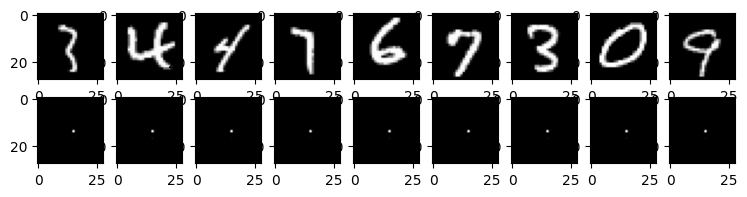

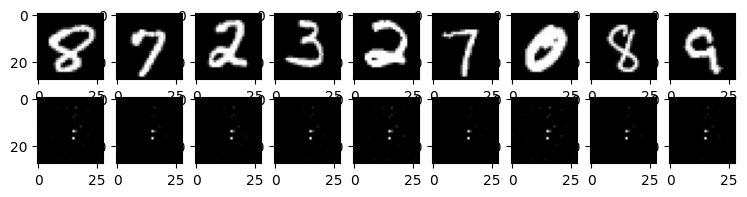

In [10]:
# Autoencoder Model Definition
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)  # Compressed representation
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training Parameters
num_epochs = 10
outputs = []  # Store results for plotting

# Training Loop
for epoch in range(num_epochs):
    for img, _ in data_loader:
        img = img.view(img.size(0), -1)  # Flatten the images
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss every epoch and store images and outputs every 5 epochs
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    if epoch % 5 == 0:
        outputs.append((epoch, img, output))

# Plotting Results
for k in range(0, len(outputs)):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9 + i + 1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])
    plt.show()



In [11]:
# Variational Autoencoder (VAE) architecture
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [12]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

-----AutoEncoder-----
Epoch 1/10, Total Loss: 0.9589066624895596
Epoch 2/10, Total Loss: 0.925367116673923
Epoch 3/10, Total Loss: 0.9253662998742386
Epoch 4/10, Total Loss: 0.925368669571907
Epoch 5/10, Total Loss: 0.9253672815080899
Epoch 6/10, Total Loss: 0.9253692853171179
Epoch 7/10, Total Loss: 0.9253681255047763
Epoch 8/10, Total Loss: 0.9253673054007833
Epoch 9/10, Total Loss: 0.9253682912285648
Epoch 10/10, Total Loss: 0.9253684615275499
-----VariationAutoEncoder-----
Epoch 1/10, Total Loss: 2.0434252638806667
Epoch 2/10, Total Loss: 0.9300858033999705
Epoch 3/10, Total Loss: 0.9273110581105197
Epoch 4/10, Total Loss: 0.9264250759885255
Epoch 5/10, Total Loss: 0.9260543705557963
Epoch 6/10, Total Loss: 0.9258640236946057
Epoch 7/10, Total Loss: 0.9257393634395559
Epoch 8/10, Total Loss: 0.9256641561034392
Epoch 9/10, Total Loss: 0.9256114710622759
Epoch 10/10, Total Loss: 0.9255626407513486


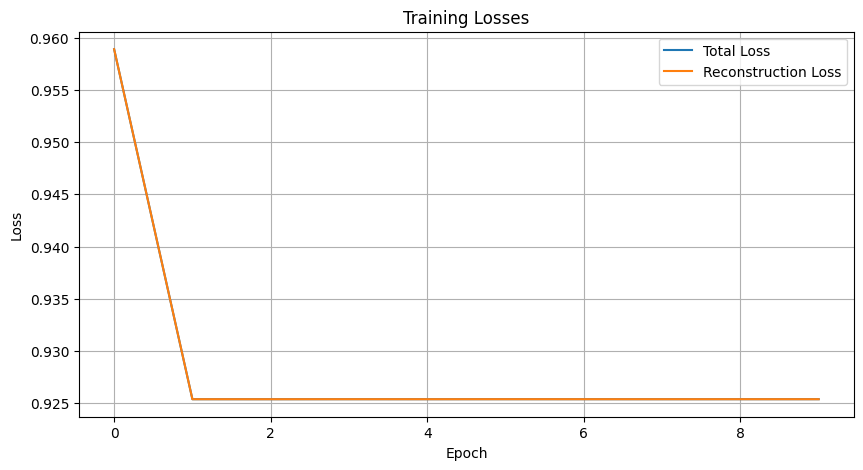

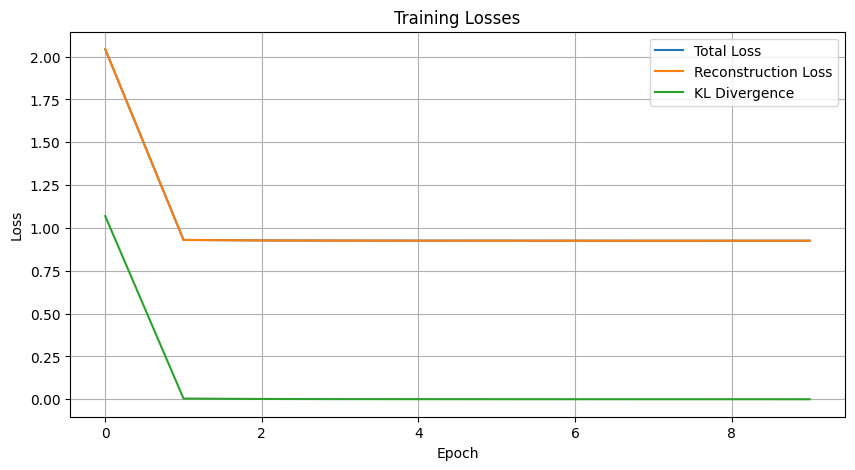

In [13]:
# Function to train the models
def train(model, train_loader, criterion, optimizer, num_epochs):
    total_losses = []
    recon_losses = []
    kld_losses = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        recon_loss = 0.0
        kld_loss = 0.0

        for data in train_loader:
            inputs, _ = data
            optimizer.zero_grad()
            if isinstance(model, VAE):
                recon_batch, mu, logvar = model(inputs)
                BCE = criterion(recon_batch, inputs.view(-1, 784))
                KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = BCE + KLD
                kld_loss += KLD.item()
            else:
                outputs = model(inputs.view(inputs.size(0), -1))
                loss = criterion(outputs, inputs.view(inputs.size(0), -1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            recon_loss += loss.item()

        total_losses.append(total_loss / len(train_loader))
        recon_losses.append(recon_loss / len(train_loader))
        if isinstance(model, VAE):
            kld_losses.append(kld_loss / len(train_loader))

        print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {total_loss/len(train_loader)}")

    return total_losses, recon_losses, kld_losses

# Define function to plot losses
def plot_losses(total_losses, recon_losses, kld_losses=None):
    plt.figure(figsize=(10, 5))
    plt.plot(total_losses, label='Total Loss')
    plt.plot(recon_losses, label='Reconstruction Loss')
    if kld_losses:
        plt.plot(kld_losses, label='KL Divergence')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

# Train AE
ae_model = Autoencoder()
ae_optimizer = optim.Adam(ae_model.parameters(), lr=0.001)
print("-----AutoEncoder-----")
ae_total_losses, ae_recon_losses, _ = train(ae_model, train_loader, criterion, ae_optimizer, num_epochs=10)

# Train VAE
vae_model = VAE()
vae_optimizer = optim.Adam(vae_model.parameters(), lr=0.001)
print("-----VariationAutoEncoder-----")
vae_total_losses, vae_recon_losses, vae_kld_losses = train(vae_model, train_loader, criterion, vae_optimizer, num_epochs=10)

# Plot losses
plot_losses(ae_total_losses, ae_recon_losses)
plot_losses(vae_total_losses, vae_recon_losses, vae_kld_losses)

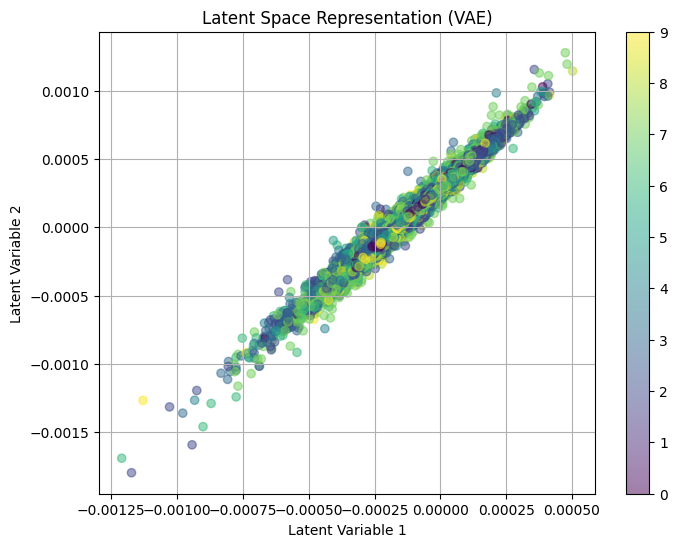

In [14]:
# Latent space representations
def generate_latent_space(model, data_loader):
    latent_space = []
    labels = []

    for data in data_loader:
        inputs, target = data
        mu, _ = model.encode(inputs.view(-1, 784))
        latent_space.append(mu.detach().numpy())
        labels.append(target.numpy())

    latent_space = np.concatenate(latent_space, axis=0)
    labels = np.concatenate(labels, axis=0)

    return latent_space, labels

# Generate latent space representations for VAE
vae_latent_space, vae_labels = generate_latent_space(vae_model, train_loader)

# Plot latent space
plt.figure(figsize=(8, 6))
plt.scatter(vae_latent_space[:, 0], vae_latent_space[:, 1], c=vae_labels, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Latent Space Representation (VAE)')
plt.grid(True)
plt.show()